In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt

fee = 1.5
delta = 0.95
account_size = 10000
stop_loss = 550

trading_days_in_year = 252

start_date = datetime.date(year=2006, month=6, day=13)
end_date = datetime.date(year=2018, month=12, day=20)
validation_date = datetime.date(year=2016, month=1, day=1)

gold = pd.read_csv('data/gold_daily.csv', index_col='Date')
gold_cot = pd.read_csv('data/gold_cot.csv', index_col='Date')

corn = pd.read_csv('data/corn_daily.csv', index_col='Date')
corn_cot = pd.read_csv('data/corn_cot.csv', index_col='Date')

coffee = pd.read_csv('data/coffee_daily.csv', index_col='Date')
coffee_cot = pd.read_csv('data/coffee_cot.csv', index_col='Date')

In [2]:
gold.index = pd.DatetimeIndex(data=gold.index)
gold_cot.index = pd.DatetimeIndex(data=gold_cot.index)

corn.index = pd.DatetimeIndex(data=corn.index)
corn_cot.index = pd.DatetimeIndex(data=corn_cot.index)

coffee.index = pd.DatetimeIndex(data=coffee.index)
coffee_cot.index = pd.DatetimeIndex(data=coffee_cot.index)

In [3]:
gold = gold.sort_index(kind='mergesort')
gold_cot = gold_cot.sort_index(kind='mergesort')
corn = corn.sort_index(kind='mergesort')
corn_cot = corn_cot.sort_index(kind='mergesort')
coffee = coffee.sort_index(kind='mergesort')
coffee_cot = coffee_cot.sort_index(kind='mergesort')

In [4]:
gold_cot.head(10)

,Open Interest,Producer/Merchant/Processor/User Longs,Producer/Merchant/Processor/User Shorts,Swap Dealer Longs,Swap Dealer Shorts,Swap Dealer Spreads,Money Manager Longs,Money Manager Shorts,Money Manager Spreads,Other Reportable Longs,Other Reportable Shorts,Other Reportable Spreads,Total Reportable Longs,Total Reportable Shorts,Non Reportable Longs,Non Reportable Shorts
Date,,,,,,,,,,,,,,,,
2006-06-13,382474.0,42587.0,128892.0,19370.0,66611.0,22998.0,103211.0,30916.0,46704.0,33230.0,10656.0,58412.0,326513.0,365190.0,55961.0,17284.0
2006-06-20,390281.0,47440.0,126992.0,22404.0,64682.0,25806.0,94632.0,30963.0,48730.0,32947.0,11142.0,64458.0,336417.0,372774.0,53864.0,17507.0
2006-06-27,384321.0,48449.0,121890.0,22425.0,62640.0,25151.0,91042.0,32287.0,49614.0,31307.0,11386.0,59762.0,327749.0,362729.0,56572.0,21592.0
2006-07-03,392868.0,48087.0,122568.0,22720.0,69714.0,26352.0,92545.0,30452.0,50821.0,32874.0,8677.0,63514.0,336914.0,372098.0,55955.0,20771.0
2006-07-11,427008.0,54509.0,130618.0,21840.0,79217.0,28805.0,104213.0,27624.0,54922.0,33165.0,11194.0,70944.0,368398.0,403323.0,58611.0,23685.0
2006-07-18,443519.0,49863.0,131166.0,21681.0,83183.0,33352.0,107413.0,24296.0,62395.0,31760.0,9442.0,74272.0,380737.0,418105.0,62782.0,25414.0
2006-07-25,432413.0,52859.0,133290.0,22956.0,85604.0,28832.0,99087.0,22386.0,64810.0,29740.0,6244.0,73980.0,372265.0,415146.0,60148.0,17266.0
2006-08-01,394609.0,45161.0,135988.0,21250.0,73244.0,23643.0,99330.0,24391.0,54618.0,32195.0,4758.0,57618.0,333815.0,374260.0,60795.0,20350.0
2006-08-08,402899.0,46203.0,142240.0,20703.0,72061.0,24259.0,104600.0,24271.0,57785.0,33123.0,6489.0,57914.0,344587.0,385020.0,58312.0,17880.0


In [5]:
def percentage_from_max(sr):
    mx = sr.max()
    mn = sr.min()
    return (sr[-1]-mn)/(mx-mn)

def max_positions_percentage(df):
    df['Prod_net_position'] = df['Producer/Merchant/Processor/User Longs'] - df['Producer/Merchant/Processor/User Shorts']
    df['Prod_net_position_perc'] = df.rolling('730d')['Prod_net_position'].apply(percentage_from_max, raw=False)
    df['Money_manager_net_position'] = df['Money Manager Longs'] - df['Money Manager Shorts']
    df['Money_manager_net_position_perc'] = df.rolling('730d')['Money_manager_net_position'].apply(percentage_from_max, raw=False)
    df = df[['Prod_net_position_perc', 'Money_manager_net_position_perc']]
    return df

In [6]:
gold_cot = max_positions_percentage(gold_cot)
corn_cot = max_positions_percentage(corn_cot)
coffee_cot = max_positions_percentage(coffee_cot)

In [7]:
# code from stockstats pypy package
def get_wr(df, n_days):
    """ Williams Overbought/Oversold Index
    WMS=[(Hn—Ct)/(Hn—Ln)] ×100
    Ct - the close price
    Hn - N days high
    Ln - N days low
    :param df: data
    :param n_days: N days
    :return: None
    """
    n_days = int(n_days)
    ln = df['Low'].rolling(min_periods=1, window=n_days,
                           center=False).min()
    hn = df['High'].rolling(min_periods=1, window=n_days,
                            center=False).max()
    column_name = 'wr_{}'.format(n_days)
    column_name = 'wr'
    df[column_name] = (hn - df['Settle']) / (hn - ln) * 100

In [8]:
def calculate_target(row):
    global fee, delta, stop_loss, treshold
    volatility = (row['Settle']-row['Open'])*delta
    if abs(volatility) > fee + treshold:
        if volatility > 0:
            return 1
        else:
            return -1
    else:
        return 0
    return df


def create_trade_outcomes(df, contracts, treshold):
    ans_df = pd.DataFrame([])
    ans_df['gains'] = (df['Settle'] - df['Open'])*0.95*contracts
    ans_df = pd.concat([ans_df, df[['Open', 'High', 'Low', 'Settle']]*contracts], axis=1)
    ans_df['target'] = ans_df.apply(calculate_target, axis=1)
    print(ans_df.head(5))
    return ans_df.shift(-1)

In [9]:
treshold = 300
contracts = 100
gold_gains = create_trade_outcomes(gold, contracts, treshold)
gold_gains.head(20)

            gains     Open     High      Low   Settle  target
Date                                                         
1996-01-02  342.0  38830.0  39200.0  38800.0  39190.0       1
1996-01-03  361.0  39240.0  39630.0  39220.0  39620.0       1
1996-01-04   95.0  39440.0  39580.0  39410.0  39540.0       0
1996-01-05 -123.5  39780.0  39920.0  39620.0  39650.0       0
1996-01-09  104.5  39580.0  39710.0  39480.0  39690.0       0


,gains,Open,High,Low,Settle,target
Date,,,,,,
1996-01-02,361.0,39240.0,39630.0,39220.0,39620.0,1.0
1996-01-03,95.0,39440.0,39580.0,39410.0,39540.0,0.0
1996-01-04,-123.5,39780.0,39920.0,39620.0,39650.0,0.0
1996-01-05,104.5,39580.0,39710.0,39480.0,39690.0,0.0
1996-01-09,228.0,39780.0,40300.0,39780.0,40020.0,0.0
1996-01-10,-66.5,40000.0,40060.0,39880.0,39930.0,0.0
1996-01-11,-361.0,40050.0,40090.0,39650.0,39670.0,-1.0
1996-01-12,133.0,39470.0,39630.0,39400.0,39610.0,0.0
1996-01-15,142.5,39730.0,39890.0,39720.0,39880.0,0.0


In [10]:
get_wr(gold, 14)
gold = pd.concat([gold, gold_gains[['target']]], axis=1)
gold.head(15)

,Open,High,Low,Settle,Volume,Prev. Day Open Interest,wr,target
Date,,,,,,,,
1996-01-02,388.3,392.0,388.0,391.9,41453.0,57500.0,2.500000,1.0
1996-01-03,392.4,396.3,392.2,396.2,102217.0,79518.0,1.204819,0.0
1996-01-04,394.4,395.8,394.1,395.4,37223.0,83787.0,10.843373,0.0
1996-01-05,397.8,399.2,396.2,396.5,49601.0,89355.0,24.107143,0.0
1996-01-09,395.8,397.1,394.8,396.9,27499.0,90634.0,20.535714,0.0
1996-01-10,397.8,403.0,397.8,400.2,74480.0,103163.0,18.666667,0.0
1996-01-11,400.0,400.6,398.8,399.3,40319.0,103776.0,24.666667,-1.0
1996-01-12,400.5,400.9,396.5,396.7,45436.0,97237.0,42.000000,0.0
1996-01-15,394.7,396.3,394.0,396.1,32344.0,95690.0,46.000000,0.0


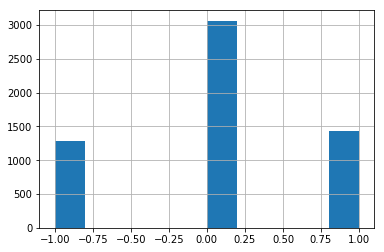

In [11]:
gold['target'].hist()

In [12]:
gold_gains.gains.describe()

count     5780.000000
mean         2.190917
std        903.824695
min     -11390.500000
25%       -237.500000
50%          9.500000
75%        294.500000
max       6555.000000
Name: gains, dtype: float64

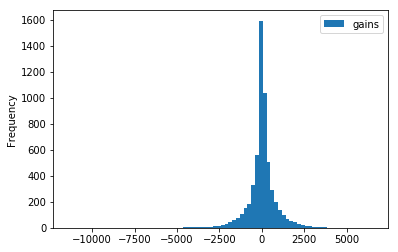

In [13]:
gold_gains[['gains']].plot.hist(bins=80)

In [14]:
# Corn Contract has 5000 bushels contract is in cents therefore 50 contracts are producing desired values
contracts = 50
treshold = 150
corn_gains = create_trade_outcomes(corn, contracts, treshold)
corn_gains.head(5)

              gains     Open     High      Low   Settle  target
Date                                                           
1996-01-02  106.875  18550.0  18762.5  18512.5  18662.5       0
1996-01-03   47.500  18650.0  18725.0  18512.5  18700.0       0
1996-01-04 -213.750  18675.0  18687.5  18250.0  18450.0      -1
1996-01-05  -11.875  18337.5  18450.0  18275.0  18325.0       0
1996-01-08 -190.000  18225.0  18225.0  18000.0  18025.0      -1


,gains,Open,High,Low,Settle,target
Date,,,,,,
1996-01-02,47.500,18650.0,18725.0,18512.5,18700.0,0.0
1996-01-03,-213.750,18675.0,18687.5,18250.0,18450.0,-1.0
1996-01-04,-11.875,18337.5,18450.0,18275.0,18325.0,0.0
1996-01-05,-190.000,18225.0,18225.0,18000.0,18025.0,-1.0
1996-01-08,368.125,17950.0,18350.0,17950.0,18337.5,1.0


In [15]:
corn_gains.gains.describe()

count    5789.000000
mean        2.203101
std       310.165899
min     -1983.125000
25%      -118.750000
50%         0.000000
75%       130.625000
max      1888.125000
Name: gains, dtype: float64

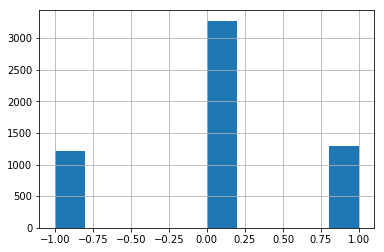

In [16]:
get_wr(corn, 14)
corn = pd.concat([corn, corn_gains[['target']]], axis=1)

corn.target.hist()

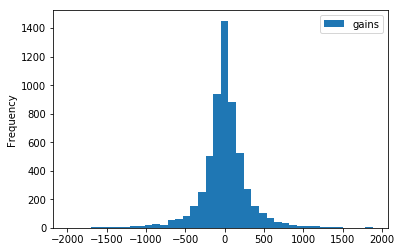

In [17]:
corn_gains[['gains']].plot.hist(bins=40)

In [18]:
corn_gains.head(10)

,gains,Open,High,Low,Settle,target
Date,,,,,,
1996-01-02,47.500,18650.0,18725.0,18512.5,18700.0,0.0
1996-01-03,-213.750,18675.0,18687.5,18250.0,18450.0,-1.0
1996-01-04,-11.875,18337.5,18450.0,18275.0,18325.0,0.0
1996-01-05,-190.000,18225.0,18225.0,18000.0,18025.0,-1.0
1996-01-08,368.125,17950.0,18350.0,17950.0,18337.5,1.0
1996-01-09,-249.375,18375.0,18375.0,18100.0,18112.5,-1.0
1996-01-10,-225.625,18112.5,18112.5,17800.0,17875.0,-1.0
1996-01-11,237.500,17887.5,18150.0,17887.5,18137.5,1.0
1996-01-12,142.500,18100.0,18262.5,18075.0,18250.0,0.0


In [19]:
# coffee contract size is 37,500 pounds price is in cents per pound
contracts = 375
treshold = 275
coffee_gains = create_trade_outcomes(coffee, contracts, treshold)
coffee_gains.head(5)

                gains     Open      High      Low    Settle  target
Date                                                               
1996-01-02  -480.9375  34725.0  35550.00  34162.5  34218.75      -1
1996-01-03  1015.3125  34087.5  35400.00  33900.0  35156.25       1
1996-01-04  1727.8125  34875.0  36787.50  34875.0  36693.75       1
1996-01-05  -445.3125  36562.5  37293.75  35925.0  36093.75      -1
1996-01-10   890.6250  35775.0  36843.75  35550.0  36712.50       1


,gains,Open,High,Low,Settle,target
Date,,,,,,
1996-01-02,1015.3125,34087.5,35400.00,33900.00,35156.25,1.0
1996-01-03,1727.8125,34875.0,36787.50,34875.00,36693.75,1.0
1996-01-04,-445.3125,36562.5,37293.75,35925.00,36093.75,-1.0
1996-01-05,890.6250,35775.0,36843.75,35550.00,36712.50,1.0
1996-01-10,1977.1875,36562.5,38812.50,36468.75,38643.75,1.0


In [20]:
coffee_gains.gains.describe()

count     5751.000000
mean        -2.638889
std        968.552015
min     -12842.812500
25%       -213.750000
50%          0.000000
75%        231.562500
max       6929.062500
Name: gains, dtype: float64

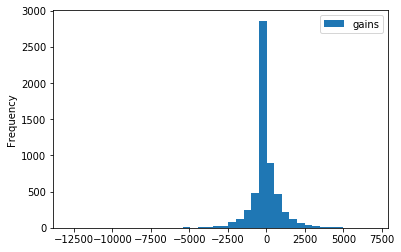

In [21]:
coffee_gains[['gains']].plot.hist(bins=40)

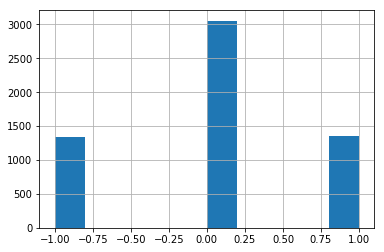

In [22]:
get_wr(coffee, 14)
coffee = pd.concat([coffee, coffee_gains[['target']]], axis=1)
coffee.target.hist()

In [23]:
coffee[coffee.target != 0].head(10)

,Open,High,Low,Settle,Volume,Prev. Day Open Interest,wr,target
Date,,,,,,,,
1996-01-02,92.60,94.80,91.10,91.25,5719.0,18717.0,95.945946,1.0
1996-01-03,90.90,94.40,90.40,93.75,6461.0,19257.0,23.863636,1.0
1996-01-04,93.00,98.10,93.00,97.85,8865.0,18918.0,3.246753,-1.0
1996-01-05,97.50,99.45,95.80,96.25,6833.0,18599.0,35.359116,1.0
1996-01-10,95.40,98.25,94.80,97.90,5146.0,18542.0,17.127072,1.0
1996-01-12,103.00,103.85,100.80,102.70,5984.0,17314.0,8.550186,-1.0
1996-01-15,102.70,103.00,98.70,98.95,6128.0,17227.0,36.431227,1.0
1996-01-16,97.75,105.25,97.75,103.90,9918.0,17601.0,9.090909,1.0
1996-01-17,103.05,105.50,103.05,104.30,6504.0,16852.0,7.947020,1.0


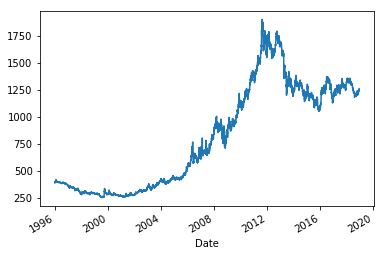

In [24]:
gold['Open'].plot()

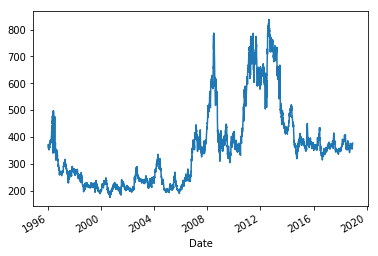

In [25]:
corn['Open'].plot()

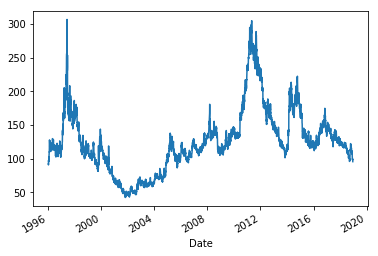

In [26]:
coffee['Open'].plot()

In [27]:
import numpy as np
import holidays

def trading_day_of_month(tm):
    ts = (tm - np.datetime64('1970-01-01')) / np.timedelta64(1, 's')
    dt = datetime.datetime.fromtimestamp(ts)
    di = datetime.date(year=dt.year, month=dt.month, day=1)
    us_holidays = holidays.UnitedStates()
    cnt = 1
    for i in range(1, 32):
        if i == dt.day:
            break
        if di.weekday() in [0, 1, 2, 3, 4] and dt not in us_holidays:
            cnt += 1
        di += datetime.timedelta(days=1)
    return cnt


def create_vectors(df, df_cot):
    global trading_days_in_year
    nv = df.shape[1]-2
    i_t = df.shape[1]-1
    ans_dct = {}
    for i in range(df.shape[0]):
        if i < 2*trading_days_in_year:
            continue
        mtrx = df.iloc[i-2*trading_days_in_year:i, 0:nv].values
        size = np.prod(mtrx.shape)
        mtrx = list(mtrx.reshape(size))
        idx = df.index.values[i]
        # add COT report to the end of list
        mtrx_cot = df_cot[df_cot.index < idx].values[-8:]
        size = np.prod(mtrx_cot.shape)
        mtrx_cot = list(mtrx_cot.reshape(size))
        if size < 16:
            mtrx_cot += [0 for i in range(16-size)]
        # Date Features
        # print(type(idx), type(idx.astype(datetime.datetime)))
        ts = (idx - np.datetime64('1970-01-01')) / np.timedelta64(1, 's')
        dt = datetime.datetime.fromtimestamp(ts)
        mtrx_date = [dt.weekday(), trading_day_of_month(idx), dt.month, (dt.month-1)//3, df.loc[idx].wr]
        # mtrx_date = [dt.weekday(), df.loc[idx].wr]
        # Combine list
        mtrx = mtrx + mtrx_cot + mtrx_date
        mtrx.append(df.iloc[i, i_t])
        ans_dct[idx] = mtrx
    return pd.DataFrame.from_dict(ans_dct, orient='index')

In [28]:
gold_data = create_vectors(gold, gold_cot)
gold_data = gold_data.loc[:end_date]
corn_data = create_vectors(corn, corn_cot)
corn_data = corn_data.loc[:end_date]
coffee_data = create_vectors(coffee, coffee_cot)
coffee_data = coffee_data.loc[:end_date]

In [29]:
gold_data.tail(20)

,0,1,2,3,4,5,6,7,8,9,...,3036,3037,3038,3039,3040,3041,3042,3043,3044,3045
2018-11-23,1213.5,1220.9,1205.6,1211.2,202123.0,199751.0,1212.6,1214.7,1181.2,1189.3,...,0.942235,0.087364,0.916625,0.162104,4,17,11,3,36.363636,0.0
2018-11-26,1212.6,1214.7,1181.2,1189.3,353644.0,164500.0,1189.4,1192.7,1170.3,1178.4,...,0.942235,0.087364,0.916625,0.162104,0,18,11,3,38.277512,-1.0
2018-11-27,1189.4,1192.7,1170.3,1178.4,288389.0,106069.0,1184.4,1197.2,1182.4,1190.8,...,0.942235,0.087364,0.916625,0.162104,1,19,11,3,59.808612,1.0
2018-11-28,1184.4,1197.2,1182.4,1190.8,177818.0,77556.0,1196.6,1197.7,1182.6,1190.8,...,0.916625,0.162104,0.957183,0.139100,2,20,11,3,21.282799,0.0
2018-11-29,1196.6,1197.7,1182.6,1190.8,196186.0,259190.0,1190.7,1196.8,1171.3,1173.9,...,0.916625,0.162104,0.957183,0.139100,3,21,11,3,19.825073,-1.0
2018-11-30,1190.7,1196.8,1171.3,1173.9,236195.0,271613.0,1175.1,1178.4,1162.2,1169.4,...,0.916625,0.162104,0.957183,0.139100,4,22,11,3,31.195335,1.0
2018-12-03,1175.1,1178.4,1162.2,1169.4,216866.0,273896.0,1174.3,1180.3,1168.4,1177.8,...,0.916625,0.162104,0.957183,0.139100,0,1,12,3,0.533333,1.0
2018-12-04,1174.3,1180.3,1168.4,1177.8,169593.0,273718.0,1182.6,1190.2,1158.6,1176.5,...,0.916625,0.162104,0.957183,0.139100,1,2,12,3,0.692841,0.0
2018-12-05,1182.6,1190.2,1158.6,1176.5,212507.0,275782.0,1172.8,1177.1,1168.1,1170.1,...,0.957183,0.139100,0.859876,0.275776,2,3,12,3,12.536443,0.0
2018-12-06,1172.8,1177.1,1168.1,1170.1,131034.0,271766.0,1171.4,1182.3,1167.2,1177.5,...,0.957183,0.139100,0.859876,0.275776,3,4,12,3,18.584071,1.0


In [30]:
gold_data.shape

(5276, 3046)

In [31]:
gold_cot.head(5)

,Prod_net_position_perc,Money_manager_net_position_perc
Date,,
2006-06-13,NaN,NaN
2006-06-20,1.000000,0.000000
2006-06-27,1.000000,0.000000
2006-07-03,0.919154,0.246529
2006-07-11,0.792600,1.000000


In [32]:
gold_data = gold_data.loc[gold_data.index >= '2007-01-01']
corn_data = corn_data.loc[corn_data.index >= '2007-01-01']
coffee_data = coffee_data.loc[coffee_data.index >= '2007-01-01']

In [33]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.decomposition import FactorAnalysis

validate_date = '2018-01-01'


def data_split_pca_transform(df):
    global validate_date
    label_index = 3045
    df_validate = df.loc[validate_date <= df.index]
    df_data_tt = df.loc[validate_date > df.index]
    df_train, df_test, label_train, label_test = train_test_split(df_data_tt[list(range(label_index))], df_data_tt[label_index], test_size=0.2, random_state=2242)
    # df_train = pd.DataFrame(df_train)
    # df_test = pd.DataFrame(df_test)

    # pca_lst = []
    # pca = PCA(n_components=50, random_state=2234)
    pca = FactorAnalysis(n_components=5, random_state=2234)
    pca.fit(df_train[list(range(3040))])
    # pca_lst.append(pca)
    
    # pca = PCA(n_components=2, random_state=2233)
    # pca.fit(df_train[list(range(2016, 2016 + 504))])
    # pca_lst.append(pca)
    
    # pca = PCA(n_components=2, random_state=2232)
    # pca.fit(df_train[list(range(2016 + 504, 2016 + 1008))])
    # pca_lst.append(pca)
    # return df_train[list(range(label_index))], df_train[label_index], df_validate[list(range(label_index))], df_validate[label_index], pca    
    return df_train, df_test, label_train, label_test, df_validate[list(range(label_index))], df_validate[label_index], pca


def pca_transform(df, pca):
    label_index = 3045
    # df_pca_lst = []
    df_pca = pca.transform(df[list(range(3040))])
    # df_pca = pd.DataFrame(df_pca, index=df.index)
    # df_pca_lst.append(df_pca)
    
    # df_pca = pca_lst[1].transform(df[list(range(2016, 2016 + 504))])
    # df_pca_lst.append(df_pca)
    
    # df_pca = pca_lst[2].transform(df[list(range(2016 + 504, 2016 + 1008))])
    # df_pca_lst.append(df_pca)
    
    df_pca = np.concatenate((df_pca, df[list(range(3040,label_index))].values), axis=1)
    # df_pca = pd.concat([df_pca, df[list(range(3040, label_index))]], axis=1)
    return df_pca

In [34]:
gold_train, gold_test, gold_label_train, gold_label_test, gold_validate, gold_label_validate, gold_pca = data_split_pca_transform(gold_data)
# gold_train, gold_label_train, gold_validate, gold_label_validate, gold_pca = data_split_pca_transform(gold_data)
corn_train, corn_test, corn_label_train, corn_label_test, corn_validate, corn_label_validate, corn_pca = data_split_pca_transform(corn_data)
coffee_train, coffee_test, coffee_label_train, coffee_label_test, coffee_validate, coffee_label_validate, coffee_pca = data_split_pca_transform(coffee_data)

In [35]:
# plt.plot(np.cumsum(gold_pca.explained_variance_ratio_))
# plt.xlabel('number of components')
# plt.ylabel('cumulative explained variance');

In [36]:
# np.cumsum(gold_pca.explained_variance_ratio_)[268]

In [37]:
gold_data.head(10)

,0,1,2,3,4,5,6,7,8,9,...,3036,3037,3038,3039,3040,3041,3042,3043,3044,3045
2007-01-02,443.3,444.0,434.4,437.0,67906.0,226150.0,436.0,439.8,434.7,438.4,...,0.531691,0.369919,0.484046,0.336928,1,2,1,0,0.000000,-1.0
2007-01-03,436.0,439.8,434.7,438.4,32949.0,217477.0,435.8,436.3,427.8,429.7,...,0.531691,0.369919,0.484046,0.336928,2,3,1,0,85.984848,0.0
2007-01-04,435.8,436.3,427.8,429.7,82846.0,208448.0,427.4,429.7,424.8,429.2,...,0.484046,0.336928,0.345193,0.474129,3,4,1,0,89.393939,-1.0
2007-01-05,427.4,429.7,424.8,429.2,54829.0,202128.0,426.3,429.3,426.1,427.3,...,0.484046,0.336928,0.345193,0.474129,4,5,1,0,96.683673,0.0
2007-01-08,426.3,429.3,426.1,427.3,43721.0,196268.0,425.7,427.0,421.1,421.6,...,0.484046,0.336928,0.345193,0.474129,0,6,1,0,94.557823,1.0
2007-01-09,425.7,427.0,421.1,421.6,65179.0,188605.0,421.2,425.8,417.1,419.5,...,0.484046,0.336928,0.345193,0.474129,1,7,1,0,89.795918,0.0
2007-01-10,421.2,425.8,417.1,419.5,97972.0,176117.0,419.7,421.3,419.5,419.7,...,0.345193,0.474129,0.801490,0.141280,2,8,1,0,91.156463,0.0
2007-01-11,419.7,421.3,419.5,419.7,34177.0,172080.0,421.3,423.3,421.1,422.4,...,0.345193,0.474129,0.801490,0.141280,3,9,1,0,90.731293,1.0
2007-01-12,421.3,423.3,421.1,422.4,46900.0,164267.0,421.7,428.3,421.1,426.6,...,0.345193,0.474129,0.801490,0.141280,4,10,1,0,79.676871,0.0
2007-01-15,421.7,428.3,421.1,426.6,64043.0,164973.0,424.1,425.5,423.6,425.1,...,0.345193,0.474129,0.801490,0.141280,0,1,1,0,10.629252,0.0


In [38]:
# %%capture cpt_gold_train
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.model_selection import GridSearchCV, GroupKFold
import lightgbm as lgb
# import xgboost as xgb

categoricals = [5, 6, 7, 8]
# categoricals = 'auto'
# categoricals = [3040,3041,3042,3043]
X = pca_transform(gold_train, gold_pca)
y = list(map(lambda x: 1 if x < 0 else 0, gold_label_train))
train_data = lgb.Dataset(X, label=y, categorical_feature=categoricals) # categorical_feature=[3040,3041,3042,3043])
X_test = pca_transform(gold_test, gold_pca)
y_test = list(map(lambda x: 1 if x < 0 else 0, gold_label_test))
test_data = lgb.Dataset(X_test, label=y_test, categorical_feature=categoricals)

gold_short = True

param = {'num_leaves':31, 'objective':'binary'}
param['objective'] = 'binary'
param['boosting'] = 'dart'
param['metric'] = 'binary_error'
param['learning_rate'] = 0.05
param['num_class'] = 1
param['max_bin'] = 50
param['reg_alpha'] = 5
param['reg_lambda'] = 10
num_round = 3000

gold_xgb_use = False
gold_clf = lgb.train(param, train_data, num_round, valid_sets=[test_data])

/home/martin/virtualenvs/oracle3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/martin/virtualenvs/oracle3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[1]	valid_0's binary_error: 0.362657
[2]	valid_0's binary_error: 0.362657
[3]	valid_0's binary_error: 0.362657
[4]	valid_0's binary_error: 0.362657
[5]	valid_0's binary_error: 0.362657
[6]	valid_0's binary_error: 0.362657
[7]	valid_0's binary_error: 0.362657
[8]	valid_0's binary_error: 0.362657
[9]	valid_0's binary_error: 0.362657
[10]	valid_0's binary_error: 0.362657
[11]	valid_0's binary_error: 0.362657
[12]	valid_0's binary_error: 0.362657
[13]	valid_0's binary_error: 0.362657
[14]	valid_0's binary_error: 0.362657
[15]	valid_0's binary_error: 0.362657
[16]	valid_0's binary_error: 0.362657
[17]	valid_0's binary_error: 0.362657
[18]	valid_0's binary_error: 0.362657
[19]	valid_0's binary_error: 0.362657
[20]	valid_0's binary_error: 0.362657
[21]	valid_0's binary_error: 0.362657
[22]	valid_0's binary_error: 0.362657
[23]	valid_0's binary_error: 0.362657
[24]	valid_0's binary_error: 0.362657
[25]	valid_0's binary_error: 0.362657
[26]	valid_0's binary_error: 0.362657
[27]	valid_0's binary

[229]	valid_0's binary_error: 0.369838
[230]	valid_0's binary_error: 0.373429
[231]	valid_0's binary_error: 0.369838
[232]	valid_0's binary_error: 0.369838
[233]	valid_0's binary_error: 0.369838
[234]	valid_0's binary_error: 0.371634
[235]	valid_0's binary_error: 0.371634
[236]	valid_0's binary_error: 0.369838
[237]	valid_0's binary_error: 0.369838
[238]	valid_0's binary_error: 0.368043
[239]	valid_0's binary_error: 0.368043
[240]	valid_0's binary_error: 0.373429
[241]	valid_0's binary_error: 0.373429
[242]	valid_0's binary_error: 0.373429
[243]	valid_0's binary_error: 0.373429
[244]	valid_0's binary_error: 0.373429
[245]	valid_0's binary_error: 0.375224
[246]	valid_0's binary_error: 0.37702
[247]	valid_0's binary_error: 0.378815
[248]	valid_0's binary_error: 0.378815
[249]	valid_0's binary_error: 0.378815
[250]	valid_0's binary_error: 0.382406
[251]	valid_0's binary_error: 0.382406
[252]	valid_0's binary_error: 0.382406
[253]	valid_0's binary_error: 0.384201
[254]	valid_0's binary_err

[462]	valid_0's binary_error: 0.384201
[463]	valid_0's binary_error: 0.384201
[464]	valid_0's binary_error: 0.384201
[465]	valid_0's binary_error: 0.387792
[466]	valid_0's binary_error: 0.385996
[467]	valid_0's binary_error: 0.384201
[468]	valid_0's binary_error: 0.384201
[469]	valid_0's binary_error: 0.382406
[470]	valid_0's binary_error: 0.382406
[471]	valid_0's binary_error: 0.382406
[472]	valid_0's binary_error: 0.382406
[473]	valid_0's binary_error: 0.384201
[474]	valid_0's binary_error: 0.385996
[475]	valid_0's binary_error: 0.385996
[476]	valid_0's binary_error: 0.385996
[477]	valid_0's binary_error: 0.384201
[478]	valid_0's binary_error: 0.384201
[479]	valid_0's binary_error: 0.384201
[480]	valid_0's binary_error: 0.384201
[481]	valid_0's binary_error: 0.384201
[482]	valid_0's binary_error: 0.384201
[483]	valid_0's binary_error: 0.385996
[484]	valid_0's binary_error: 0.385996
[485]	valid_0's binary_error: 0.385996
[486]	valid_0's binary_error: 0.385996
[487]	valid_0's binary_er

[703]	valid_0's binary_error: 0.389587
[704]	valid_0's binary_error: 0.389587
[705]	valid_0's binary_error: 0.389587
[706]	valid_0's binary_error: 0.389587
[707]	valid_0's binary_error: 0.389587
[708]	valid_0's binary_error: 0.389587
[709]	valid_0's binary_error: 0.389587
[710]	valid_0's binary_error: 0.387792
[711]	valid_0's binary_error: 0.387792
[712]	valid_0's binary_error: 0.387792
[713]	valid_0's binary_error: 0.387792
[714]	valid_0's binary_error: 0.391382
[715]	valid_0's binary_error: 0.391382
[716]	valid_0's binary_error: 0.393178
[717]	valid_0's binary_error: 0.393178
[718]	valid_0's binary_error: 0.393178
[719]	valid_0's binary_error: 0.393178
[720]	valid_0's binary_error: 0.393178
[721]	valid_0's binary_error: 0.393178
[722]	valid_0's binary_error: 0.393178
[723]	valid_0's binary_error: 0.393178
[724]	valid_0's binary_error: 0.391382
[725]	valid_0's binary_error: 0.391382
[726]	valid_0's binary_error: 0.391382
[727]	valid_0's binary_error: 0.393178
[728]	valid_0's binary_er

[937]	valid_0's binary_error: 0.391382
[938]	valid_0's binary_error: 0.394973
[939]	valid_0's binary_error: 0.394973
[940]	valid_0's binary_error: 0.394973
[941]	valid_0's binary_error: 0.394973
[942]	valid_0's binary_error: 0.396768
[943]	valid_0's binary_error: 0.396768
[944]	valid_0's binary_error: 0.396768
[945]	valid_0's binary_error: 0.396768
[946]	valid_0's binary_error: 0.396768
[947]	valid_0's binary_error: 0.394973
[948]	valid_0's binary_error: 0.394973
[949]	valid_0's binary_error: 0.394973
[950]	valid_0's binary_error: 0.394973
[951]	valid_0's binary_error: 0.394973
[952]	valid_0's binary_error: 0.396768
[953]	valid_0's binary_error: 0.394973
[954]	valid_0's binary_error: 0.394973
[955]	valid_0's binary_error: 0.393178
[956]	valid_0's binary_error: 0.394973
[957]	valid_0's binary_error: 0.396768
[958]	valid_0's binary_error: 0.396768
[959]	valid_0's binary_error: 0.396768
[960]	valid_0's binary_error: 0.396768
[961]	valid_0's binary_error: 0.398564
[962]	valid_0's binary_er

[1165]	valid_0's binary_error: 0.394973
[1166]	valid_0's binary_error: 0.393178
[1167]	valid_0's binary_error: 0.393178
[1168]	valid_0's binary_error: 0.394973
[1169]	valid_0's binary_error: 0.394973
[1170]	valid_0's binary_error: 0.394973
[1171]	valid_0's binary_error: 0.393178
[1172]	valid_0's binary_error: 0.393178
[1173]	valid_0's binary_error: 0.391382
[1174]	valid_0's binary_error: 0.391382
[1175]	valid_0's binary_error: 0.391382
[1176]	valid_0's binary_error: 0.389587
[1177]	valid_0's binary_error: 0.389587
[1178]	valid_0's binary_error: 0.389587
[1179]	valid_0's binary_error: 0.389587
[1180]	valid_0's binary_error: 0.389587
[1181]	valid_0's binary_error: 0.391382
[1182]	valid_0's binary_error: 0.393178
[1183]	valid_0's binary_error: 0.391382
[1184]	valid_0's binary_error: 0.391382
[1185]	valid_0's binary_error: 0.391382
[1186]	valid_0's binary_error: 0.391382
[1187]	valid_0's binary_error: 0.389587
[1188]	valid_0's binary_error: 0.393178
[1189]	valid_0's binary_error: 0.393178


[1402]	valid_0's binary_error: 0.40754
[1403]	valid_0's binary_error: 0.409336
[1404]	valid_0's binary_error: 0.409336
[1405]	valid_0's binary_error: 0.40754
[1406]	valid_0's binary_error: 0.40754
[1407]	valid_0's binary_error: 0.409336
[1408]	valid_0's binary_error: 0.409336
[1409]	valid_0's binary_error: 0.411131
[1410]	valid_0's binary_error: 0.409336
[1411]	valid_0's binary_error: 0.409336
[1412]	valid_0's binary_error: 0.409336
[1413]	valid_0's binary_error: 0.409336
[1414]	valid_0's binary_error: 0.409336
[1415]	valid_0's binary_error: 0.409336
[1416]	valid_0's binary_error: 0.411131
[1417]	valid_0's binary_error: 0.411131
[1418]	valid_0's binary_error: 0.411131
[1419]	valid_0's binary_error: 0.411131
[1420]	valid_0's binary_error: 0.411131
[1421]	valid_0's binary_error: 0.411131
[1422]	valid_0's binary_error: 0.411131
[1423]	valid_0's binary_error: 0.411131
[1424]	valid_0's binary_error: 0.411131
[1425]	valid_0's binary_error: 0.411131
[1426]	valid_0's binary_error: 0.411131
[14

[1617]	valid_0's binary_error: 0.423698
[1618]	valid_0's binary_error: 0.423698
[1619]	valid_0's binary_error: 0.423698
[1620]	valid_0's binary_error: 0.425494
[1621]	valid_0's binary_error: 0.429084
[1622]	valid_0's binary_error: 0.427289
[1623]	valid_0's binary_error: 0.427289
[1624]	valid_0's binary_error: 0.429084
[1625]	valid_0's binary_error: 0.425494
[1626]	valid_0's binary_error: 0.423698
[1627]	valid_0's binary_error: 0.423698
[1628]	valid_0's binary_error: 0.423698
[1629]	valid_0's binary_error: 0.425494
[1630]	valid_0's binary_error: 0.427289
[1631]	valid_0's binary_error: 0.425494
[1632]	valid_0's binary_error: 0.425494
[1633]	valid_0's binary_error: 0.425494
[1634]	valid_0's binary_error: 0.425494
[1635]	valid_0's binary_error: 0.425494
[1636]	valid_0's binary_error: 0.425494
[1637]	valid_0's binary_error: 0.425494
[1638]	valid_0's binary_error: 0.425494
[1639]	valid_0's binary_error: 0.423698
[1640]	valid_0's binary_error: 0.423698
[1641]	valid_0's binary_error: 0.423698


[1855]	valid_0's binary_error: 0.414722
[1856]	valid_0's binary_error: 0.416517
[1857]	valid_0's binary_error: 0.414722
[1858]	valid_0's binary_error: 0.414722
[1859]	valid_0's binary_error: 0.412926
[1860]	valid_0's binary_error: 0.412926
[1861]	valid_0's binary_error: 0.414722
[1862]	valid_0's binary_error: 0.414722
[1863]	valid_0's binary_error: 0.412926
[1864]	valid_0's binary_error: 0.412926
[1865]	valid_0's binary_error: 0.412926
[1866]	valid_0's binary_error: 0.412926
[1867]	valid_0's binary_error: 0.414722
[1868]	valid_0's binary_error: 0.414722
[1869]	valid_0's binary_error: 0.414722
[1870]	valid_0's binary_error: 0.414722
[1871]	valid_0's binary_error: 0.414722
[1872]	valid_0's binary_error: 0.412926
[1873]	valid_0's binary_error: 0.412926
[1874]	valid_0's binary_error: 0.411131
[1875]	valid_0's binary_error: 0.411131
[1876]	valid_0's binary_error: 0.411131
[1877]	valid_0's binary_error: 0.411131
[1878]	valid_0's binary_error: 0.411131
[1879]	valid_0's binary_error: 0.411131


[2083]	valid_0's binary_error: 0.414722
[2084]	valid_0's binary_error: 0.416517
[2085]	valid_0's binary_error: 0.418312
[2086]	valid_0's binary_error: 0.418312
[2087]	valid_0's binary_error: 0.418312
[2088]	valid_0's binary_error: 0.416517
[2089]	valid_0's binary_error: 0.416517
[2090]	valid_0's binary_error: 0.416517
[2091]	valid_0's binary_error: 0.416517
[2092]	valid_0's binary_error: 0.416517
[2093]	valid_0's binary_error: 0.418312
[2094]	valid_0's binary_error: 0.418312
[2095]	valid_0's binary_error: 0.418312
[2096]	valid_0's binary_error: 0.418312
[2097]	valid_0's binary_error: 0.418312
[2098]	valid_0's binary_error: 0.418312
[2099]	valid_0's binary_error: 0.418312
[2100]	valid_0's binary_error: 0.418312
[2101]	valid_0's binary_error: 0.418312
[2102]	valid_0's binary_error: 0.418312
[2103]	valid_0's binary_error: 0.418312
[2104]	valid_0's binary_error: 0.416517
[2105]	valid_0's binary_error: 0.421903
[2106]	valid_0's binary_error: 0.420108
[2107]	valid_0's binary_error: 0.420108


[2303]	valid_0's binary_error: 0.429084
[2304]	valid_0's binary_error: 0.429084
[2305]	valid_0's binary_error: 0.429084
[2306]	valid_0's binary_error: 0.429084
[2307]	valid_0's binary_error: 0.429084
[2308]	valid_0's binary_error: 0.429084
[2309]	valid_0's binary_error: 0.427289
[2310]	valid_0's binary_error: 0.427289
[2311]	valid_0's binary_error: 0.429084
[2312]	valid_0's binary_error: 0.429084
[2313]	valid_0's binary_error: 0.429084
[2314]	valid_0's binary_error: 0.429084
[2315]	valid_0's binary_error: 0.429084
[2316]	valid_0's binary_error: 0.429084
[2317]	valid_0's binary_error: 0.429084
[2318]	valid_0's binary_error: 0.429084
[2319]	valid_0's binary_error: 0.429084
[2320]	valid_0's binary_error: 0.429084
[2321]	valid_0's binary_error: 0.429084
[2322]	valid_0's binary_error: 0.429084
[2323]	valid_0's binary_error: 0.429084
[2324]	valid_0's binary_error: 0.429084
[2325]	valid_0's binary_error: 0.429084
[2326]	valid_0's binary_error: 0.429084
[2327]	valid_0's binary_error: 0.429084


[2534]	valid_0's binary_error: 0.423698
[2535]	valid_0's binary_error: 0.421903
[2536]	valid_0's binary_error: 0.421903
[2537]	valid_0's binary_error: 0.421903
[2538]	valid_0's binary_error: 0.421903
[2539]	valid_0's binary_error: 0.421903
[2540]	valid_0's binary_error: 0.421903
[2541]	valid_0's binary_error: 0.421903
[2542]	valid_0's binary_error: 0.421903
[2543]	valid_0's binary_error: 0.425494
[2544]	valid_0's binary_error: 0.425494
[2545]	valid_0's binary_error: 0.427289
[2546]	valid_0's binary_error: 0.427289
[2547]	valid_0's binary_error: 0.427289
[2548]	valid_0's binary_error: 0.427289
[2549]	valid_0's binary_error: 0.427289
[2550]	valid_0's binary_error: 0.427289
[2551]	valid_0's binary_error: 0.427289
[2552]	valid_0's binary_error: 0.427289
[2553]	valid_0's binary_error: 0.429084
[2554]	valid_0's binary_error: 0.427289
[2555]	valid_0's binary_error: 0.429084
[2556]	valid_0's binary_error: 0.429084
[2557]	valid_0's binary_error: 0.429084
[2558]	valid_0's binary_error: 0.429084


[2744]	valid_0's binary_error: 0.421903
[2745]	valid_0's binary_error: 0.421903
[2746]	valid_0's binary_error: 0.421903
[2747]	valid_0's binary_error: 0.421903
[2748]	valid_0's binary_error: 0.421903
[2749]	valid_0's binary_error: 0.421903
[2750]	valid_0's binary_error: 0.421903
[2751]	valid_0's binary_error: 0.421903
[2752]	valid_0's binary_error: 0.423698
[2753]	valid_0's binary_error: 0.423698
[2754]	valid_0's binary_error: 0.423698
[2755]	valid_0's binary_error: 0.423698
[2756]	valid_0's binary_error: 0.423698
[2757]	valid_0's binary_error: 0.423698
[2758]	valid_0's binary_error: 0.423698
[2759]	valid_0's binary_error: 0.423698
[2760]	valid_0's binary_error: 0.423698
[2761]	valid_0's binary_error: 0.423698
[2762]	valid_0's binary_error: 0.423698
[2763]	valid_0's binary_error: 0.423698
[2764]	valid_0's binary_error: 0.423698
[2765]	valid_0's binary_error: 0.423698
[2766]	valid_0's binary_error: 0.423698
[2767]	valid_0's binary_error: 0.423698
[2768]	valid_0's binary_error: 0.421903


[2974]	valid_0's binary_error: 0.43088
[2975]	valid_0's binary_error: 0.43088
[2976]	valid_0's binary_error: 0.43088
[2977]	valid_0's binary_error: 0.43088
[2978]	valid_0's binary_error: 0.43088
[2979]	valid_0's binary_error: 0.43088
[2980]	valid_0's binary_error: 0.43088
[2981]	valid_0's binary_error: 0.43088
[2982]	valid_0's binary_error: 0.432675
[2983]	valid_0's binary_error: 0.432675
[2984]	valid_0's binary_error: 0.43447
[2985]	valid_0's binary_error: 0.43447
[2986]	valid_0's binary_error: 0.432675
[2987]	valid_0's binary_error: 0.43447
[2988]	valid_0's binary_error: 0.43447
[2989]	valid_0's binary_error: 0.43447
[2990]	valid_0's binary_error: 0.43447
[2991]	valid_0's binary_error: 0.43447
[2992]	valid_0's binary_error: 0.43447
[2993]	valid_0's binary_error: 0.43447
[2994]	valid_0's binary_error: 0.43447
[2995]	valid_0's binary_error: 0.43447
[2996]	valid_0's binary_error: 0.43447
[2997]	valid_0's binary_error: 0.43447
[2998]	valid_0's binary_error: 0.43447
[2999]	valid_0's binar

In [39]:
%%capture cpt_corn_train
X = pca_transform(corn_train, corn_pca)

y = list(map(lambda x: 1 if x < 0 else 0, corn_label_train))
train_data = lgb.Dataset(X, label=y, categorical_feature='auto')
X_test = pca_transform(corn_test, corn_pca)
y_test = list(map(lambda x: 1 if x < 0 else 0, corn_label_test))
test_data = lgb.Dataset(X_test, label=y_test, categorical_feature='auto')
corn_short = True
corn_clf = lgb.train(param, train_data, num_round, valid_sets=[test_data])

In [40]:
%%capture cpt_coffee_train
param['max_bin'] = 10
X = pca_transform(coffee_train, coffee_pca)

train_data = lgb.Dataset(X, label=list(map(lambda x: 1 if x < 0 else 0, coffee_label_train)), categorical_feature='auto')
X_test = pca_transform(coffee_test, coffee_pca)
test_data = lgb.Dataset(X_test, label=list(map(lambda x: 1 if x < 0 else 0, coffee_label_test)), categorical_feature='auto')
coffee_short = True
coffee_clf = lgb.train(param, train_data, num_round, valid_sets=[test_data])

In [208]:
# rework with numpy cumsum

def get_performance(model, pca, df_gains, df, labels, short=False, multi_class=False, stop_loss=500, vector=False):
    global account_size, fee
    acc = account_size
    df = pca_transform(df, pca)
    if short:
        target = -1
    else:
        target = 1
    preds = model.predict(df)
    print(np.unique(preds))
    if vector:
        preds = [p[0] for p in preds]
        # ps = []
        # for p, r in preds:
        #     if p > 0.5 and p > r:
        #         ps.append(p)
        # preds = ps
    predictions = []
    if not multi_class:
        mx = 0
        for p in preds:
            if p > mx:
                print(mx)
                mx = p
            if p > 0.5:
                predictions.append(target)
            else:
                predictions.append(0)
    else:
        mx = 0
        for t, n in preds:
            if t > mx:
                print(mx)
                mx = t
            if t > 0.5:
                print(t, n)
                predictions.append(target)
            else:
                predictions.append(0)
    dct = {}
    dct['account'] = [acc]
    dct['trade'] = [0]
    dct['label'] = [0]
    dct['short'] = [0]
    dct['long'] = [0]
    dct['trade'] = [0]
    dct['label'] = [0]
    dct['stop_loss'] = [0]
    dct['gains'] = [0]
    for p, l, v in zip(predictions, labels, df_gains.values):
        # print(p,l)
        # print(p)
        short = 0
        long = 0
        s_l = 0
        gains = 0
        if p == -1:
            # print("Short ", p, l)
            short = 1
            if (v[2] - v[1]) > stop_loss:
                gains = -stop_loss
                s_l = 1
            else:
                gains = -v[0] - fee
        elif p == 1:
            long = 1
            if (v[1] - v[3]) > stop_loss:
                gains = -stop_loss
                s_l = 1
            else:
                gains = v[0] - fee
        acc += gains
        dct['account'].append(acc)
        dct['short'].append(short)
        dct['long'].append(long)
        dct['stop_loss'].append(s_l)
        dct['trade'].append(p)
        dct['label'].append(l)
        dct['gains'].append(gains)
        if acc <= 0:
            break
    return pd.DataFrame.from_dict(dct)

[0.36273876 0.12695803 0.73799778 0.26299565 0.14049859 0.08842746
 0.12631828 0.32990458 0.24717781 0.24261218 0.28810716 0.20856314
 0.19971203 0.17526538 0.504427   0.22312204 0.3918224  0.26222656
 0.24223399 0.2289103  0.16324244 0.29050572 0.09500619 0.08058463
 0.19676748 0.11588238 0.17045166 0.11246822 0.08326721 0.13606299
 0.12004193 0.04822599 0.11779925 0.16291536 0.35888063 0.15467129
 0.14707534 0.22436374 0.21638528 0.3336414  0.48117589 0.53484682
 0.5001186  0.5514355  0.36806192 0.30100926 0.27574746 0.38532227
 0.4023809  0.64981854 0.26718665 0.33901361 0.27387335 0.3137352
 0.67182207 0.38202934 0.4483     0.50226047 0.79877839 0.58837933
 0.38805046 0.44278141 0.46805513 0.1673813  0.39985619 0.38883052
 0.19955414 0.30360639 0.33182163 0.35010163 0.20255237 0.2086693
 0.30618229 0.15933444 0.29594739 0.49618733 0.20480559 0.57195061
 0.27909355 0.12121152 0.17639022 0.62765672 0.19819878 0.21834044
 0.19815235 0.4058485  0.38273586 0.4800878  0.33129986 0.368208

(0, 18000)

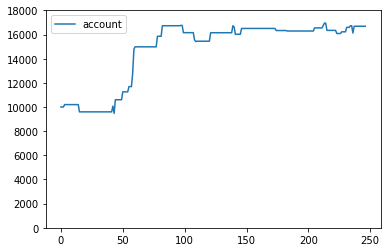

In [176]:
gold_account = get_performance(gold_clf, gold_pca, gold_gains.loc[gold_gains.index > validate_date], gold_validate, gold_label_validate, short=gold_short, stop_loss=600)
ax1 = gold_account[['account']].plot()
ax1.set_ylim(0,18000)

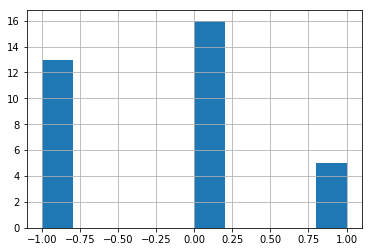

In [177]:
gold_account[gold_account.short == 1].label.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0950a1b940>,
      dtype=object)

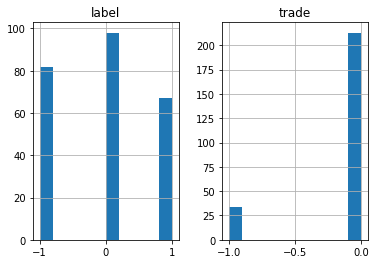

In [178]:
gold_account[['trade', 'label']].hist()

In [179]:
gold_account[gold_account['short'] == 1].gains.sum()

6684.5

In [180]:
gold_account[gold_account['long'] == 1].gains.sum()

0.0

[0.24864967 0.25926906 0.20770647 0.24803346 0.29556609 0.24768688
 0.2182343  0.17549588 0.22033114 0.17270487 0.26419139 0.29771002
 0.30830694 0.41475145 0.27316982 0.44876677 0.35607039 0.48411973
 0.50391785 0.46899536 0.49393889 0.36669133 0.28198913 0.29169111
 0.34935598 0.36060282 0.40108183 0.40501307 0.44922447 0.40507735
 0.37127114 0.3775922  0.38935695 0.34495326 0.43116664 0.46670405
 0.42562284 0.45646702 0.41160761 0.50144302 0.39296509 0.33528956
 0.38000796 0.38576123 0.41005968 0.3929805  0.48633551 0.48439112
 0.36192513 0.38793113 0.25012404 0.20892917 0.25974381 0.18325186
 0.21420822 0.2103281  0.2352259  0.26202429 0.22026495 0.27502066
 0.49671117 0.52489792 0.27296868 0.36428533 0.37697784 0.43164058
 0.45178742 0.40751083 0.4199298  0.40137589 0.44461178 0.3509624
 0.22938015 0.43950326 0.44711055 0.50731702 0.42363484 0.34458518
 0.38506022 0.41975798 0.44602032 0.43392793 0.36654816 0.26663587
 0.44760863 0.44161322 0.51746376 0.4324431  0.59367562 0.61666

(0, 14000)

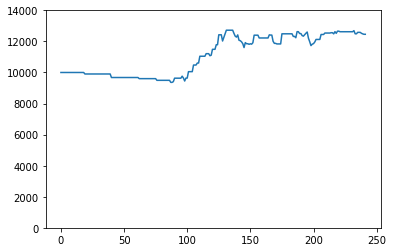

In [181]:
corn_account = get_performance(corn_clf, corn_pca, corn_gains.loc[corn_gains.index > validate_date], corn_validate, corn_label_validate, short=True, stop_loss=400)
ax1 = corn_account.account.plot()
ax1.set_ylim(0,14000)

In [182]:
corn_account[corn_account['short'] == 1].gains.sum()

2459.25

In [183]:
corn_account[corn_account['long'] == 1].gains.sum()

0.0

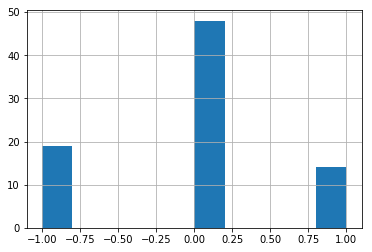

In [184]:
corn_account[corn_account.short == 1].label.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0950746cf8>,
      dtype=object)

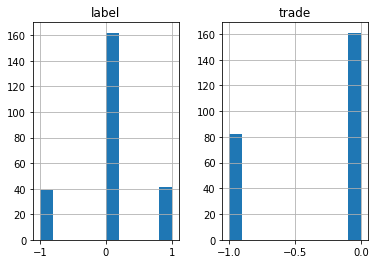

In [185]:
corn_account[['trade', 'label']].hist()

[0.43780203 0.41152994 0.40992981 0.36907404 0.38259967 0.37405107
 0.35828533 0.43959581 0.43853913 0.41943189 0.40003388 0.44127079
 0.37180942 0.41910294 0.40159748 0.38664539 0.40021839 0.3576055
 0.43965995 0.42178575 0.4069306  0.44343555 0.33862181 0.45017433
 0.38475035 0.36890629 0.42771019 0.3768506  0.45077294 0.44124426
 0.44192374 0.48416005 0.33798435 0.43331205 0.39964678 0.47391034
 0.39035943 0.42776066 0.43885431 0.42649262 0.51280721 0.3767186
 0.44600808 0.40341288 0.37155091 0.41715401 0.37879217 0.44409162
 0.39642076 0.41954445 0.41067811 0.33318683 0.43661697 0.41176661
 0.41865569 0.49300538 0.3208234  0.43501505 0.42274687 0.3844684
 0.4386     0.45437915 0.42207797 0.37959722 0.41667163 0.36907297
 0.42898337 0.39301562 0.39494356 0.47399681 0.37700392 0.44065106
 0.40192342 0.37580906 0.40760631 0.36377882 0.42725036 0.46245688
 0.4201745  0.4924555  0.38771642 0.46407789 0.48548481 0.48693487
 0.5388536  0.36487345 0.51226156 0.51509297 0.44149504 0.4673769

(0, 19000)

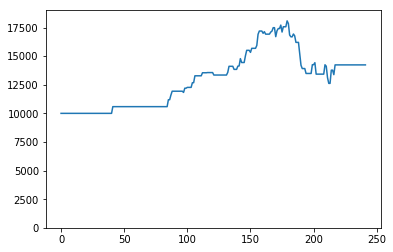

In [186]:
coffee_account = get_performance(coffee_clf, coffee_pca, coffee_gains.loc[coffee_gains.index > validate_date], coffee_validate, coffee_label_validate, short=coffee_short, stop_loss=1000)
ax1 = coffee_account.account.plot()
ax1.set_ylim(0,19000)

In [187]:
coffee_account[coffee_account['short'] == 1].gains.sum()

4234.937500000002

In [188]:
coffee_account[coffee_account['long'] == 1].gains.sum()

0.0

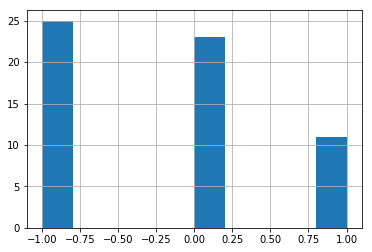

In [189]:
coffee_account[coffee_account.short == 1].label.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f09505829e8>,
      dtype=object)

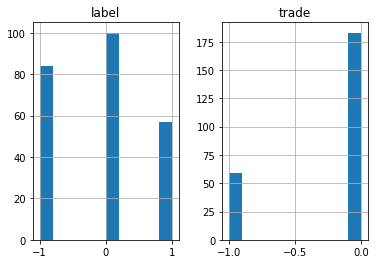

In [190]:
coffee_account[['trade', 'label']].hist()

In [191]:
# %%capture gold_long_train
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network import MLPClassifier

# categoricals = [5, 6, 7, 8]
X = pca_transform(gold_train, gold_pca)
# print(X[0])
# enc = OneHotEncoder(handle_unknown='ignore', categorical_features=categoricals)
# enc = OneHotEncoder()
# print(OneHotEncoder(X[:,5]))
# print(type(X))
# X = enc.fit_transform(X[:,5:9])
# print(X[0])
y = list(map(lambda x: 1 if x > 0 else 0, gold_label_train))
# train_data = lgb.Dataset(X, label=y, categorical_feature=categoricals) # categorical_feature=[3040,3041,3042,3043])
X_test = pca_transform(gold_test, gold_pca)
y_test = list(map(lambda x: 1 if x > 0 else 0, gold_label_test))
# test_data = lgb.Dataset(X_test, label=y_test, categorical_feature=categoricals)

# param = {'num_leaves':31, 'objective':'binary'}
# param['objective'] = 'binary'
# param['boosting'] = 'dart'
# param['metric'] = 'binary_error'
# param['learning_rate'] = 0.05
# param['num_class'] = 1
# param['max_bin'] = 30
# param['reg_alpha'] = 5
# param['reg_lambda'] = 10
# num_round = 3000

# gold_short = False
# gold_clf_long = lgb.train(param, train_data, num_round, valid_sets=[test_data])
# gold_clf_long = RandomForestClassifier(n_estimators=200)
gold_clf_long = MLPClassifier(solver='lbfgs', alpha=1e-2,
                              hidden_layer_sizes=(10, 20, 2), random_state=55431)
gold_clf_long.fit(np.concatenate([X, X_test]), np.concatenate([y, y_test]))

MLPClassifier(activation='relu', alpha=0.01, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10, 20, 2), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=55431, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [192]:
%%capture training_gold
# from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, Activation, LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Nadam
from keras.models import Sequential
from keras import regularizers

X_train = np.concatenate([X, X_test])
# print(np.concatenate([y, y_test]).sum())
y_train = np.array([[1,0] if i==1 else [0,0] for i in np.concatenate([y, y_test])])
# y_train = np.concatenate([y, y_test])
# print(y_train[:5])

input_shape = (10, )
num_classes = 1

# Define a model
model = Sequential()  
model.add(Dense(64, input_dim=10, activity_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))
model.add(Dense(16, activity_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dense(2))
model.add(Activation('softmax'))

# model = Sequential()
# model.add(Dense(500, input_shape=input_shape))
# model.add(Activation('relu'))
# model.add(Dropout(0.25))
# model.add(Dense(250))
# model.add(Activation('relu'))
# model.add(Dense(1))
# model.add(Activation('sigmoid'))

# model.compile(optimizer='adam', loss='mse')
opt = Nadam(lr=0.002)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=50)

model.summary()

In [193]:
gold_clf_long = model

[[9.9995565e-01 4.4313681e-05]
 [9.9995542e-01 4.4600314e-05]
 [9.9995506e-01 4.4960481e-05]
 [9.9995482e-01 4.5182784e-05]
 [9.9995506e-01 4.4959968e-05]
 [9.9995422e-01 4.5779751e-05]
 [9.9995422e-01 4.5722507e-05]
 [9.9995422e-01 4.5749417e-05]
 [9.9995410e-01 4.5881581e-05]
 [9.9995399e-01 4.6020847e-05]
 [9.9995387e-01 4.6189725e-05]
 [9.9995244e-01 4.7615398e-05]
 [9.9995255e-01 4.7451125e-05]
 [9.9995244e-01 4.7510981e-05]
 [9.9995279e-01 4.7242796e-05]
 [9.9995315e-01 4.6892517e-05]
 [9.9995315e-01 4.6889028e-05]
 [9.9995184e-01 4.8113056e-05]
 [9.9995112e-01 4.8817587e-05]
 [9.9995089e-01 4.9110356e-05]
 [9.9995065e-01 4.9384438e-05]
 [9.9995291e-01 4.7107023e-05]
 [9.9995124e-01 4.8808099e-05]
 [9.9995124e-01 4.8795020e-05]
 [9.9995029e-01 4.9674109e-05]
 [9.9994946e-01 5.0528310e-05]
 [9.9995005e-01 4.9925289e-05]
 [9.9994957e-01 5.0398041e-05]
 [9.9995065e-01 4.9364331e-05]
 [9.9995077e-01 4.9204908e-05]
 [9.9995363e-01 4.6356832e-05]
 [9.9995303e-01 4.6909150e-05]
 [9.9995

(0, 18000)

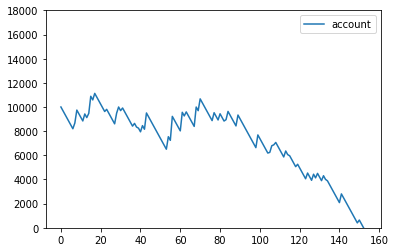

In [194]:
gold_account_long = get_performance(gold_clf_long, gold_pca, gold_gains.loc[gold_gains.index > validate_date], gold_validate, gold_label_validate, short=False, stop_loss=300, multi_class=True, vector=False)
ax1 = gold_account_long[['account']].plot()
ax1.set_ylim(0,18000)

In [195]:
gold_account_long[gold_account_long['long'] == 1].gains.sum()

-10257.499999999936

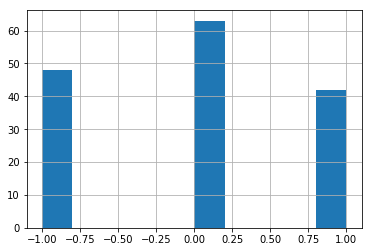

In [196]:
gold_account_long[gold_account_long['long'] == 1].label.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f094f3d6550>,
      dtype=object)

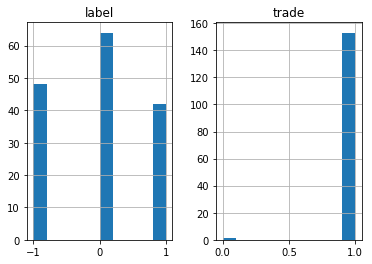

In [197]:
gold_account_long[['trade', 'label']].hist()

In [215]:
# %%capture cpt_corn_train
import keras_metrics
X = pca_transform(corn_train, corn_pca)
X_test = pca_transform(corn_test, corn_pca)

y = list(map(lambda x: 1 if x > 0 else 0, corn_label_train))
y_test = list(map(lambda x: 1 if x > 0 else 0, corn_label_test))

# y = np.array([[1,0] if i==1 else [0,0] for i in y])
# print(y)
# y_test = np.array([[1,0] if i==1 else [0,0] for i in y_test])
# print(y_test)

# X_train = np.concatenate([X, X_test])

model = Sequential()  
model.add(Dense(32, input_dim=10, activity_regularizer=regularizers.l2(0.01)))
# model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))
model.add(Dense(16, activity_regularizer=regularizers.l2(0.01)))
# model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dense(1))
model.add(Activation('softmax'))

opt = Nadam(lr=0.02)

#  loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.compile(optimizer=opt,
              loss="binary_crossentropy",
              metrics=[keras_metrics.precision()])
# , keras_metrics.recall()
model.fit(X, y, epochs=20, validation_data=(X_test, y_test), batch_size=128, shuffle=True)

model.summary()

corn_clf_long = model

Train on 2221 samples, validate on 556 samples
Epoch 1/20
2221/2221 [==============================] - 2s 925us/step - loss: 5368.0508 - precision: 0.3215 - val_loss: 534.9583 - val_precision: 0.3165
Epoch 2/20
2221/2221 [==============================] - 0s 37us/step - loss: 336.9140 - precision: 0.3215 - val_loss: 181.7599 - val_precision: 0.3165
Epoch 3/20
2221/2221 [==============================] - 0s 30us/step - loss: 152.2085 - precision: 0.3215 - val_loss: 97.2999 - val_precision: 0.3165
Epoch 4/20
2221/2221 [==============================] - 0s 40us/step - loss: 85.4536 - precision: 0.3215 - val_loss: 58.4525 - val_precision: 0.3165
Epoch 5/20
2221/2221 [==============================] - 0s 37us/step - loss: 52.8872 - precision: 0.3215 - val_loss: 37.9861 - val_precision: 0.3165
Epoch 6/20
2221/2221 [==============================] - 0s 33us/step - loss: 34.6108 - precision: 0.3215 - val_loss: 26.7641 - val_precision: 0.3165
Epoch 7/20
2221/2221 [==============================

[1.]
0


(0, 18000)

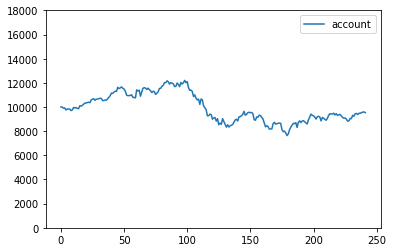

In [213]:
corn_account_long = get_performance(corn_clf_long, corn_pca, corn_gains.loc[corn_gains.index > validate_date], corn_validate, corn_label_validate, short=False, stop_loss=500, vector=True, multi_class=False)
ax1 = corn_account_long[['account']].plot()
ax1.set_ylim(0,18000)

In [214]:
corn_account_long[corn_account_long['long'] == 1].gains.sum()

-466.6250000000002

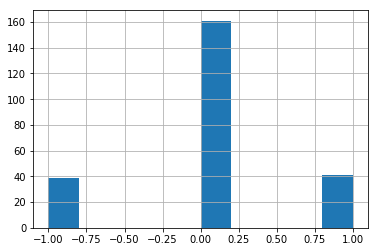

In [201]:
corn_account_long[corn_account_long['long'] == 1].label.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f09513cdf98>,
      dtype=object)

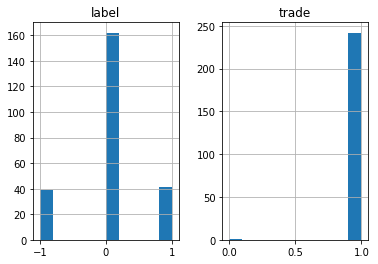

In [170]:
corn_account_long[['trade', 'label']].hist()

In [67]:
# %%capture cpt_coffee_train
param['max_bin'] = 10
X = pca_transform(coffee_train, coffee_pca)
X_test = pca_transform(coffee_test, coffee_pca)
y = list(map(lambda x: 1 if x < 0 else 0, coffee_label_test))
model = Sequential()  
model.add(Dense(64, input_dim=10, activity_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))
model.add(Dense(16, activity_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dense(2))
model.add(Activation('softmax'))

opt = Nadam(lr=0.002)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=2)

model.summary()

corn_clf_long = model
coffee_clf_long = lgb.train(param, train_data, num_round, valid_sets=[test_data])

[1]	valid_0's binary_error: 0.351986
[2]	valid_0's binary_error: 0.351986
[3]	valid_0's binary_error: 0.351986
[4]	valid_0's binary_error: 0.351986
[5]	valid_0's binary_error: 0.351986
[6]	valid_0's binary_error: 0.351986
[7]	valid_0's binary_error: 0.351986
[8]	valid_0's binary_error: 0.351986
[9]	valid_0's binary_error: 0.351986
[10]	valid_0's binary_error: 0.351986
[11]	valid_0's binary_error: 0.351986
[12]	valid_0's binary_error: 0.351986
[13]	valid_0's binary_error: 0.351986
[14]	valid_0's binary_error: 0.351986
[15]	valid_0's binary_error: 0.351986
[16]	valid_0's binary_error: 0.351986
[17]	valid_0's binary_error: 0.351986
[18]	valid_0's binary_error: 0.351986
[19]	valid_0's binary_error: 0.351986
[20]	valid_0's binary_error: 0.351986
[21]	valid_0's binary_error: 0.351986
[22]	valid_0's binary_error: 0.351986
[23]	valid_0's binary_error: 0.351986
[24]	valid_0's binary_error: 0.351986
[25]	valid_0's binary_error: 0.351986
[26]	valid_0's binary_error: 0.351986
[27]	valid_0's binary

[262]	valid_0's binary_error: 0.351986
[263]	valid_0's binary_error: 0.351986
[264]	valid_0's binary_error: 0.351986
[265]	valid_0's binary_error: 0.351986
[266]	valid_0's binary_error: 0.351986
[267]	valid_0's binary_error: 0.351986
[268]	valid_0's binary_error: 0.351986
[269]	valid_0's binary_error: 0.351986
[270]	valid_0's binary_error: 0.351986
[271]	valid_0's binary_error: 0.351986
[272]	valid_0's binary_error: 0.351986
[273]	valid_0's binary_error: 0.351986
[274]	valid_0's binary_error: 0.351986
[275]	valid_0's binary_error: 0.351986
[276]	valid_0's binary_error: 0.351986
[277]	valid_0's binary_error: 0.351986
[278]	valid_0's binary_error: 0.351986
[279]	valid_0's binary_error: 0.351986
[280]	valid_0's binary_error: 0.351986
[281]	valid_0's binary_error: 0.351986
[282]	valid_0's binary_error: 0.351986
[283]	valid_0's binary_error: 0.351986
[284]	valid_0's binary_error: 0.351986
[285]	valid_0's binary_error: 0.351986
[286]	valid_0's binary_error: 0.351986
[287]	valid_0's binary_er

[488]	valid_0's binary_error: 0.351986
[489]	valid_0's binary_error: 0.351986
[490]	valid_0's binary_error: 0.351986
[491]	valid_0's binary_error: 0.351986
[492]	valid_0's binary_error: 0.351986
[493]	valid_0's binary_error: 0.351986
[494]	valid_0's binary_error: 0.351986
[495]	valid_0's binary_error: 0.351986
[496]	valid_0's binary_error: 0.351986
[497]	valid_0's binary_error: 0.351986
[498]	valid_0's binary_error: 0.351986
[499]	valid_0's binary_error: 0.351986
[500]	valid_0's binary_error: 0.351986
[501]	valid_0's binary_error: 0.351986
[502]	valid_0's binary_error: 0.351986
[503]	valid_0's binary_error: 0.351986
[504]	valid_0's binary_error: 0.351986
[505]	valid_0's binary_error: 0.351986
[506]	valid_0's binary_error: 0.351986
[507]	valid_0's binary_error: 0.351986
[508]	valid_0's binary_error: 0.351986
[509]	valid_0's binary_error: 0.351986
[510]	valid_0's binary_error: 0.351986
[511]	valid_0's binary_error: 0.351986
[512]	valid_0's binary_error: 0.351986
[513]	valid_0's binary_er

[764]	valid_0's binary_error: 0.351986
[765]	valid_0's binary_error: 0.351986
[766]	valid_0's binary_error: 0.351986
[767]	valid_0's binary_error: 0.351986
[768]	valid_0's binary_error: 0.351986
[769]	valid_0's binary_error: 0.351986
[770]	valid_0's binary_error: 0.351986
[771]	valid_0's binary_error: 0.351986
[772]	valid_0's binary_error: 0.351986
[773]	valid_0's binary_error: 0.351986
[774]	valid_0's binary_error: 0.351986
[775]	valid_0's binary_error: 0.351986
[776]	valid_0's binary_error: 0.351986
[777]	valid_0's binary_error: 0.351986
[778]	valid_0's binary_error: 0.351986
[779]	valid_0's binary_error: 0.351986
[780]	valid_0's binary_error: 0.351986
[781]	valid_0's binary_error: 0.351986
[782]	valid_0's binary_error: 0.351986
[783]	valid_0's binary_error: 0.351986
[784]	valid_0's binary_error: 0.351986
[785]	valid_0's binary_error: 0.351986
[786]	valid_0's binary_error: 0.351986
[787]	valid_0's binary_error: 0.351986
[788]	valid_0's binary_error: 0.351986
[789]	valid_0's binary_er

[1030]	valid_0's binary_error: 0.351986
[1031]	valid_0's binary_error: 0.351986
[1032]	valid_0's binary_error: 0.351986
[1033]	valid_0's binary_error: 0.351986
[1034]	valid_0's binary_error: 0.351986
[1035]	valid_0's binary_error: 0.351986
[1036]	valid_0's binary_error: 0.351986
[1037]	valid_0's binary_error: 0.351986
[1038]	valid_0's binary_error: 0.351986
[1039]	valid_0's binary_error: 0.351986
[1040]	valid_0's binary_error: 0.351986
[1041]	valid_0's binary_error: 0.351986
[1042]	valid_0's binary_error: 0.351986
[1043]	valid_0's binary_error: 0.351986
[1044]	valid_0's binary_error: 0.351986
[1045]	valid_0's binary_error: 0.351986
[1046]	valid_0's binary_error: 0.351986
[1047]	valid_0's binary_error: 0.351986
[1048]	valid_0's binary_error: 0.351986
[1049]	valid_0's binary_error: 0.351986
[1050]	valid_0's binary_error: 0.351986
[1051]	valid_0's binary_error: 0.351986
[1052]	valid_0's binary_error: 0.351986
[1053]	valid_0's binary_error: 0.351986
[1054]	valid_0's binary_error: 0.351986


[1308]	valid_0's binary_error: 0.351986
[1309]	valid_0's binary_error: 0.351986
[1310]	valid_0's binary_error: 0.351986
[1311]	valid_0's binary_error: 0.351986
[1312]	valid_0's binary_error: 0.351986
[1313]	valid_0's binary_error: 0.351986
[1314]	valid_0's binary_error: 0.351986
[1315]	valid_0's binary_error: 0.351986
[1316]	valid_0's binary_error: 0.351986
[1317]	valid_0's binary_error: 0.351986
[1318]	valid_0's binary_error: 0.351986
[1319]	valid_0's binary_error: 0.351986
[1320]	valid_0's binary_error: 0.351986
[1321]	valid_0's binary_error: 0.351986
[1322]	valid_0's binary_error: 0.351986
[1323]	valid_0's binary_error: 0.351986
[1324]	valid_0's binary_error: 0.351986
[1325]	valid_0's binary_error: 0.351986
[1326]	valid_0's binary_error: 0.351986
[1327]	valid_0's binary_error: 0.351986
[1328]	valid_0's binary_error: 0.351986
[1329]	valid_0's binary_error: 0.351986
[1330]	valid_0's binary_error: 0.351986
[1331]	valid_0's binary_error: 0.351986
[1332]	valid_0's binary_error: 0.351986


[1516]	valid_0's binary_error: 0.353791
[1517]	valid_0's binary_error: 0.353791
[1518]	valid_0's binary_error: 0.353791
[1519]	valid_0's binary_error: 0.353791
[1520]	valid_0's binary_error: 0.353791
[1521]	valid_0's binary_error: 0.353791
[1522]	valid_0's binary_error: 0.353791
[1523]	valid_0's binary_error: 0.353791
[1524]	valid_0's binary_error: 0.353791
[1525]	valid_0's binary_error: 0.353791
[1526]	valid_0's binary_error: 0.353791
[1527]	valid_0's binary_error: 0.353791
[1528]	valid_0's binary_error: 0.353791
[1529]	valid_0's binary_error: 0.353791
[1530]	valid_0's binary_error: 0.353791
[1531]	valid_0's binary_error: 0.353791
[1532]	valid_0's binary_error: 0.353791
[1533]	valid_0's binary_error: 0.353791
[1534]	valid_0's binary_error: 0.353791
[1535]	valid_0's binary_error: 0.353791
[1536]	valid_0's binary_error: 0.353791
[1537]	valid_0's binary_error: 0.353791
[1538]	valid_0's binary_error: 0.353791
[1539]	valid_0's binary_error: 0.353791
[1540]	valid_0's binary_error: 0.353791


[1818]	valid_0's binary_error: 0.351986
[1819]	valid_0's binary_error: 0.351986
[1820]	valid_0's binary_error: 0.351986
[1821]	valid_0's binary_error: 0.351986
[1822]	valid_0's binary_error: 0.351986
[1823]	valid_0's binary_error: 0.351986
[1824]	valid_0's binary_error: 0.351986
[1825]	valid_0's binary_error: 0.351986
[1826]	valid_0's binary_error: 0.351986
[1827]	valid_0's binary_error: 0.351986
[1828]	valid_0's binary_error: 0.351986
[1829]	valid_0's binary_error: 0.351986
[1830]	valid_0's binary_error: 0.351986
[1831]	valid_0's binary_error: 0.351986
[1832]	valid_0's binary_error: 0.351986
[1833]	valid_0's binary_error: 0.351986
[1834]	valid_0's binary_error: 0.351986
[1835]	valid_0's binary_error: 0.351986
[1836]	valid_0's binary_error: 0.351986
[1837]	valid_0's binary_error: 0.351986
[1838]	valid_0's binary_error: 0.351986
[1839]	valid_0's binary_error: 0.351986
[1840]	valid_0's binary_error: 0.351986
[1841]	valid_0's binary_error: 0.351986
[1842]	valid_0's binary_error: 0.351986


[2052]	valid_0's binary_error: 0.351986
[2053]	valid_0's binary_error: 0.351986
[2054]	valid_0's binary_error: 0.351986
[2055]	valid_0's binary_error: 0.351986
[2056]	valid_0's binary_error: 0.351986
[2057]	valid_0's binary_error: 0.351986
[2058]	valid_0's binary_error: 0.351986
[2059]	valid_0's binary_error: 0.351986
[2060]	valid_0's binary_error: 0.351986
[2061]	valid_0's binary_error: 0.351986
[2062]	valid_0's binary_error: 0.351986
[2063]	valid_0's binary_error: 0.351986
[2064]	valid_0's binary_error: 0.351986
[2065]	valid_0's binary_error: 0.351986
[2066]	valid_0's binary_error: 0.351986
[2067]	valid_0's binary_error: 0.351986
[2068]	valid_0's binary_error: 0.351986
[2069]	valid_0's binary_error: 0.351986
[2070]	valid_0's binary_error: 0.351986
[2071]	valid_0's binary_error: 0.351986
[2072]	valid_0's binary_error: 0.351986
[2073]	valid_0's binary_error: 0.351986
[2074]	valid_0's binary_error: 0.351986
[2075]	valid_0's binary_error: 0.351986
[2076]	valid_0's binary_error: 0.351986


[2269]	valid_0's binary_error: 0.353791
[2270]	valid_0's binary_error: 0.353791
[2271]	valid_0's binary_error: 0.353791
[2272]	valid_0's binary_error: 0.353791
[2273]	valid_0's binary_error: 0.353791
[2274]	valid_0's binary_error: 0.353791
[2275]	valid_0's binary_error: 0.353791
[2276]	valid_0's binary_error: 0.353791
[2277]	valid_0's binary_error: 0.353791
[2278]	valid_0's binary_error: 0.353791
[2279]	valid_0's binary_error: 0.353791
[2280]	valid_0's binary_error: 0.353791
[2281]	valid_0's binary_error: 0.353791
[2282]	valid_0's binary_error: 0.353791
[2283]	valid_0's binary_error: 0.353791
[2284]	valid_0's binary_error: 0.353791
[2285]	valid_0's binary_error: 0.353791
[2286]	valid_0's binary_error: 0.353791
[2287]	valid_0's binary_error: 0.353791
[2288]	valid_0's binary_error: 0.353791
[2289]	valid_0's binary_error: 0.353791
[2290]	valid_0's binary_error: 0.353791
[2291]	valid_0's binary_error: 0.353791
[2292]	valid_0's binary_error: 0.353791
[2293]	valid_0's binary_error: 0.353791


[2586]	valid_0's binary_error: 0.353791
[2587]	valid_0's binary_error: 0.353791
[2588]	valid_0's binary_error: 0.353791
[2589]	valid_0's binary_error: 0.353791
[2590]	valid_0's binary_error: 0.353791
[2591]	valid_0's binary_error: 0.353791
[2592]	valid_0's binary_error: 0.353791
[2593]	valid_0's binary_error: 0.353791
[2594]	valid_0's binary_error: 0.353791
[2595]	valid_0's binary_error: 0.353791
[2596]	valid_0's binary_error: 0.353791
[2597]	valid_0's binary_error: 0.353791
[2598]	valid_0's binary_error: 0.353791
[2599]	valid_0's binary_error: 0.353791
[2600]	valid_0's binary_error: 0.353791
[2601]	valid_0's binary_error: 0.353791
[2602]	valid_0's binary_error: 0.353791
[2603]	valid_0's binary_error: 0.353791
[2604]	valid_0's binary_error: 0.353791
[2605]	valid_0's binary_error: 0.353791
[2606]	valid_0's binary_error: 0.353791
[2607]	valid_0's binary_error: 0.353791
[2608]	valid_0's binary_error: 0.353791
[2609]	valid_0's binary_error: 0.353791
[2610]	valid_0's binary_error: 0.353791


[2816]	valid_0's binary_error: 0.353791
[2817]	valid_0's binary_error: 0.353791
[2818]	valid_0's binary_error: 0.353791
[2819]	valid_0's binary_error: 0.353791
[2820]	valid_0's binary_error: 0.353791
[2821]	valid_0's binary_error: 0.353791
[2822]	valid_0's binary_error: 0.353791
[2823]	valid_0's binary_error: 0.353791
[2824]	valid_0's binary_error: 0.353791
[2825]	valid_0's binary_error: 0.353791
[2826]	valid_0's binary_error: 0.353791
[2827]	valid_0's binary_error: 0.353791
[2828]	valid_0's binary_error: 0.353791
[2829]	valid_0's binary_error: 0.353791
[2830]	valid_0's binary_error: 0.353791
[2831]	valid_0's binary_error: 0.353791
[2832]	valid_0's binary_error: 0.353791
[2833]	valid_0's binary_error: 0.353791
[2834]	valid_0's binary_error: 0.353791
[2835]	valid_0's binary_error: 0.353791
[2836]	valid_0's binary_error: 0.353791
[2837]	valid_0's binary_error: 0.353791
[2838]	valid_0's binary_error: 0.353791
[2839]	valid_0's binary_error: 0.353791
[2840]	valid_0's binary_error: 0.353791


0
0.50224106089347
0.509262799090763
0.548865646750256
0.5889686239981899
0.5983702981003012
0.6134319719351231
0.6385920403026503


(0, 18000)

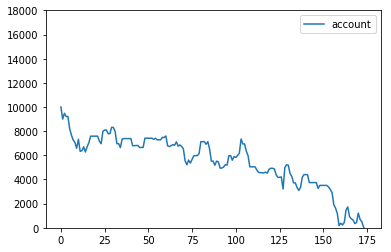

In [68]:
coffee_account_long = get_performance(coffee_clf_long, coffee_pca, coffee_gains.loc[coffee_gains.index > validate_date], corn_validate, coffee_label_validate, short=coffee_short, stop_loss=1000)
ax1 = coffee_account_long[['account']].plot()
ax1.set_ylim(0,18000)